In [28]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
train_data=shuffle(pd.read_csv('train.csv'))
val_data=shuffle(pd.read_csv('val.csv'))
unlabeled_data=shuffle(pd.read_csv('unlabeled_v2.csv'))

In [10]:
#train_data=train_data[:5000]
#val_data=val_data[:10000]

#### scorer

In [3]:
f1 = make_scorer(f1_score , average='macro')

# Data exploring

<BarContainer object of 3 artists>

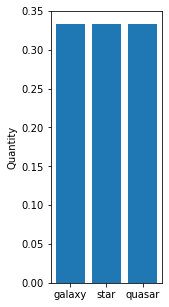

In [5]:
names = ['galaxy', 'star', 'quasar']
counts = train_data['class'].value_counts([0,1,2])
plt.figure(figsize=(2, 5))
plt.ylabel('Quantity')
plt.bar(names, counts)

#### train_data balanced

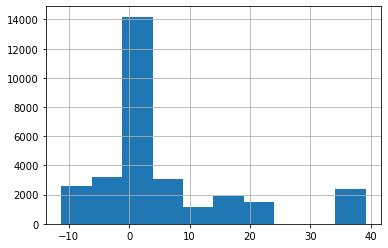

In [6]:
h = train_data['dec'].hist()
fig = h.get_figure()

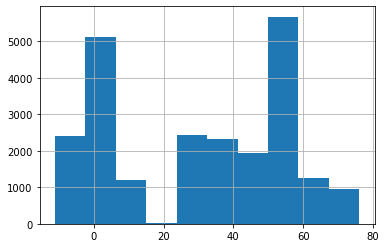

In [7]:
h = val_data['dec'].hist()
fig = h.get_figure()

#### как видим огромная часть val_data.dec лежит в диапазоне  от 30 до 70; в train_data почти все значения dec лежат возле 0

# Functions

In [4]:
def preprocessing(data: pd.DataFrame):
    f = 'class' in data
    if f:
        labels=data['class']
        data=data.drop(columns='class')
    data=data.apply(pd.to_numeric)
    data=data.drop(columns=['objid', 'ra', 'dec'])
    #data=data.drop(columns=['objid'])
    if f:
        return (data, labels)
    else:
        return data

def null_processing(data: pd.DataFrame)  ->  pd.DataFrame:
    data=data.replace({'na':np.NaN})
    data.fillna(data.median(), inplace=True)
    return data

def null_knn(data: pd.DataFrame)  ->  pd.DataFrame:
    data=data.replace({'na':np.NaN})
    imputer = KNNImputer(n_neighbors=30,metric='nan_euclidean')
    data = pd.DataFrame(imputer.fit_transform(data),columns = data.columns)
    return data

def predict_info(predict):
    a0=0
    a1=0
    a2=0
    for j in predict:
        if j==0:
            a0+=1
        elif j==1:
            a1+=1
        elif j==2:
            a2+=1
    print(a0,a1,a2)

In [5]:
def Clustering1(data: pd.DataFrame, train_data: pd.DataFrame)->pd.DataFrame:
    for band in ['u','g','r','i','z']:
        columns = []
        for i in range(6):
            s=band+'_'+str(i)
            columns.append(s)
        cluster_name='cluster_'+band
        model = KMeans(n_clusters = 10, random_state = 42)
        model.fit(train_data[columns])
        data[cluster_name]=model.predict(data[columns])
    return data

def Clustering2(data: pd.DataFrame, train_data: pd.DataFrame)->pd.DataFrame:
    for i in range(6):
        columns = []
        for band in ['u','g','r','i','z']:
            s=band+'_'+str(i)
            columns.append(s)
        cluster_name='cluster_'+str(i)
        model = KMeans(n_clusters = 10, random_state = 42)
        model.fit(train_data[columns])
        data[cluster_name]=model.predict(data[columns])
    return data

# Null processing

In [6]:
#unlabeled_data=null_processing(unlabeled_data)
#train_data=null_processing(train_data)
#val_data=null_processing(val_data)

unlabeled_data=null_knn(unlabeled_data)
train_data=null_knn(train_data)
val_data=null_knn(val_data)

In [7]:
train_data.head()

,objid,ra,dec,u_0,g_0,r_0,i_0,z_0,clean,rowc,...,g_5,r_5,i_5,z_5,u_6,g_6,r_6,i_6,z_6,class
0,61104.0,145.554540,0.822526,25.764190,22.22675,20.650010,19.63022,19.133000,1.0,68.15861,...,-0.079279,0.012070,-0.013209,2.170595,6.0,3.0,1.0,5.0,5.0,1.0
1,44262.0,157.671743,0.788167,20.956300,19.11906,17.697710,17.14728,16.766690,0.0,1364.31900,...,0.061822,0.056448,0.005643,-0.148074,3.0,5.0,5.0,6.0,3.0,1.0
2,21842.0,13.667472,14.419690,21.780868,20.41343,19.470778,18.17762,19.274078,1.0,412.80400,...,-0.046716,-0.019383,-0.017093,0.032382,3.0,4.0,7.0,1.0,3.0,1.0
3,99045.0,22.272581,38.258710,22.377636,23.62236,22.093510,22.69098,23.168520,1.0,1117.44900,...,-0.199757,0.236870,0.583948,0.703718,3.0,3.0,6.0,4.0,4.0,0.0
4,35112.0,169.206700,-1.038348,19.624070,18.36040,17.747800,17.31829,17.066840,1.0,96.82549,...,0.094282,-0.330661,0.012400,-0.344516,3.0,5.0,1.0,5.0,5.0,1.0


# Data preprocessing

In [8]:
train_data, train_labels = preprocessing(train_data)
val_data, val_labels = preprocessing(val_data)
unlabeled_data = preprocessing(unlabeled_data)

# Clustering

In [9]:
train_data=Clustering1(train_data, pd.concat([train_data, unlabeled_data]))
val_data=Clustering1(val_data, pd.concat([train_data, unlabeled_data]))
unlabeled_data = Clustering1(unlabeled_data, pd.concat([train_data, unlabeled_data]))
train_data=Clustering2(train_data, pd.concat([train_data, unlabeled_data]))
val_data=Clustering2(val_data, pd.concat([train_data, unlabeled_data]))
unlabeled_data = Clustering2(unlabeled_data, pd.concat([train_data, unlabeled_data]))

#train_data=Clustering1(train_data,unlabeled_data)
#val_data=Clustering1(val_data, unlabeled_data)
#unlabeled_data = Clustering1(unlabeled_data, unlabeled_data)
#train_data=Clustering2(train_data, unlabeled_data)
#val_data=Clustering2(val_data, unlabeled_data)
#unlabeled_data = Clustering2(unlabeled_data, unlabeled_data)

In [68]:
train_data.tail()

,u_0,g_0,r_0,i_0,z_0,clean,rowc,colc,rowv,colv,...,cluster_g,cluster_r,cluster_i,cluster_z,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
25111,19.764770,19.154450,19.09823,19.09519,18.88353,1,1371.8680,1485.7910,0.004435,0.003774,...,4,2,0,0,6,6,7,6,0,0
25769,19.244930,18.732560,18.71110,18.45509,18.43127,1,891.8050,771.7614,-0.001387,-0.000877,...,9,1,8,3,6,0,9,6,0,0
11079,21.322970,18.897760,17.61562,17.09844,16.77241,1,1310.5040,296.2054,-0.005698,0.000023,...,3,8,9,4,1,6,2,6,0,0
23151,22.322765,21.248595,16.45072,15.50724,14.95377,1,140.9857,1579.8820,0.000428,0.000099,...,7,0,4,2,1,5,7,6,0,0
16897,18.012980,16.951320,16.55226,16.32358,16.16546,1,264.5943,720.4135,-0.001850,-0.002254,...,0,5,3,6,8,1,9,6,0,0


# Models

## XGB

In [30]:
    
params = { 
    'learning_rate': 0.025,
    'n_estimators': 1000,
    'max_depth': 6,
    'subsample': 0.75,
    'colsample_bytree': 0.5,
    'gamma': 1
}
mlflow.set_experiment('XGB')
with mlflow.start_run():
    model = XGBClassifier(**params, random_state=42)
    model.fit(train_data, train_labels)
    score = f1_score(model.predict(val_data), val_labels, average='macro')
    print('f1: ', score)
    mlflow.log_param('params', params)
    mlflow.log_metric('f1_macro', score)
#0.8436

Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\mlflow\store\tracking\file_store.py", line 237, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "D:\anaconda\lib\site-packages\mlflow\store\tracking\file_store.py", line 311, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "D:\anaconda\lib\site-packages\mlflow\utils\file_utils.py", line 170, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\David\Desktop\$machine learning solves\planets\mlruns\mlruns\meta.yaml' does not exist.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1

[20:42:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1:  0.843634461423992


In [11]:
cv_score = cross_validate(model, train_data, train_labels, cv=4, scoring=["f1_micro", "f1_macro", "f1_weighted"], n_jobs=-1)
cv_score

{'fit_time': array([330.58698869, 330.93393612, 329.68051052, 329.07034397]),
 'score_time': array([0.30182457, 0.23414087, 0.37853456, 0.37652969]),
 'test_f1_micro': array([0.85986667, 0.85733333, 0.85826667, 0.854     ]),
 'test_f1_macro': array([0.85974624, 0.85711929, 0.85796376, 0.85411483]),
 'test_f1_weighted': array([0.85974624, 0.85711929, 0.85796376, 0.85411483])}

In [12]:
cv_score['test_f1_macro'].mean()
#0.857

0.8572360333430123

In [ ]:
a0=0
a1=0
a2=0
#print(len(train_data))
#print(len(model.predict
for i,j in enumerate(model.predict(val_data)):
    if j==0:
        a0+=1
    elif j==1:
        a1+=1
    elif j==2:
        a2+=1
print(a0,a1,a2)

In [ ]:
f1_score(model.predict(val_data), val_labels, average='macro')

#### gridsearch(XGB)

In [20]:
params = {
    'random_state': [42],
    'tree_method': ['hist'],
    'grow_policy': ['lossguide'],
    'n_estimators': [500,1000],
    'eta': [0.01,0.02,0.03],
    'max_depth': [2,3,4,5,6],
    'min_child_weight': [1],
    'max_bin': [120,240],
    'subsample': [0.5,0.8,0.95],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],

}

In [42]:
GridS.best_params_

{'eta': 0.02,
 'grow_policy': 'lossguide',
 'max_bin': 120,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'random_state': 42,
 'reg_lambda': 100.0,
 'subsample': 0.5,
 'tree_method': 'hist'}

## SVM

In [56]:
params = {'C': 0.1, 'coef0': 0.001, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
model = SVC(**params)
clf = make_pipeline(StandardScaler(), model)
#print('cv accuracy: ', cross_val_score(clf, train_data, train_labels, scoring='accuracy', cv = 10).mean())
clf.fit(train_data, train_labels)
predictions_SVM = clf.predict(val_data)
print('f1: ', f1_score(clf.predict(val_data), val_labels,average='macro'))

f1:  0.7707807340941862


#### gridsearch(SVM)

In [73]:
params = {
    'kernel' : ['rbf'],
    'C' : [0.1,0.5,1],
    'degree': [3,6,9],
    'coef0': [0.001,2],
    'gamma': ('auto', 'scale')
}

In [74]:
GSmodel=SVC()
GridS = GridSearchCV(GSmodel,params, cv=3,verbose=3, n_jobs=-1,scoring=f1)
GridS.fit(train_data, train_labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 41.0min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'coef0': [0.001, 2],
                         'degree': [3, 6, 9], 'gamma': ('auto', 'scale'),
                         'kernel': ['rbf']},
             scoring=make_scorer(f1_score, average=macro), verbose=3)

In [75]:
GridS.best_params_

{'C': 0.1, 'coef0': 0.001, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

In [60]:
predict_info(predictions_SVM)

16392 3648 3293


In [59]:
a0=0
a1=0
a2=0
for i,j in enumerate(clf.predict(val_data)):
    if j==0:
        a0+=1
    elif j==1:
        a1+=1
    elif j==2:
        a2+=1
print(a0,a1,a2)

16392 3648 3293


# RF

In [57]:
params = {"n_estimators": 10,
    "criterion": "gini",
    "min_samples_split": 10,
    "max_features": "auto",
    "bootstrap": True,
    "n_jobs": -1}
model = RandomForestClassifier(**params)
#print('cv accuracy: ', cross_val_score(model, train_data, train_labels, scoring='accuracy', cv = 10).mean())
model.fit(train_data, train_labels)
predictions_RF = model.predict(val_data)
print('f1: ', f1_score(model.predict(val_data), val_labels, average='macro'))

f1:  0.8021061899825855


In [15]:
rfc_knn_score = cross_validate(model, train_data, train_labels, cv=10, scoring=["f1_micro", "f1_macro", "f1_weighted"], n_jobs=-1)
rfc_knn_score

{'fit_time': array([1.91488361, 1.31097293, 1.95794892, 1.20080781, 1.25388598,
        1.48122883, 1.5463264 , 1.74062085, 1.16174889, 1.18077779]),
 'score_time': array([0.02002859, 0.57286286, 0.37256098, 0.64597249, 0.46469951,
        0.35553455, 0.30245638, 0.65098214, 0.02203393, 0.01702523]),
 'test_f1_micro': array([0.817     , 0.81066667, 0.81433333, 0.80366667, 0.85066667,
        0.831     , 0.836     , 0.849     , 0.83366667, 0.826     ]),
 'test_f1_macro': array([0.81616898, 0.81071378, 0.81400467, 0.8039977 , 0.85038787,
        0.82993452, 0.8351612 , 0.84830815, 0.83349679, 0.82619007]),
 'test_f1_weighted': array([0.81616898, 0.81071378, 0.81400467, 0.8039977 , 0.85038787,
        0.82993452, 0.8351612 , 0.84830815, 0.83349679, 0.82619007])}

In [ ]:
for k, v in rfc_knn_score.items():
    print(k, np.mean(v))

In [10]:
predict_info(predictions_RF)

15140 418 7775


# kNN

In [72]:
params={'n_neighbors': 13}
model = KNeighborsClassifier(**params)
clf = make_pipeline(StandardScaler(), model)
clf.fit(train_data, train_labels)

predictions_kNN = clf.predict(val_data)
print('f1: ', f1_score(clf.predict(val_data), val_labels, average='macro'))

f1:  0.7255196853171865


In [70]:
predict_info(predictions_kNN)

14569 3560 5204


In [15]:
model = KMeans(n_clusters = 10, random_state = 42)

# Feature importance (XGB)

In [14]:
importance = model.feature_importances_.squeeze()
columns = train_data.columns

In [26]:
res = dict(zip(columns, importance)) 
res

{'u_0': 0.02138557,
 'g_0': 0.05248179,
 'r_0': 0.030337384,
 'i_0': 0.037116125,
 'z_0': 0.048464473,
 'clean': 0.089074925,
 'rowc': 0.0062960708,
 'colc': 0.006659851,
 'rowv': 0.008507476,
 'colv': 0.011087694,
 'u_1': 0.0064582834,
 'g_1': 0.006460147,
 'r_1': 0.006756885,
 'i_1': 0.0066626086,
 'z_1': 0.006719044,
 'u_2': 0.006486106,
 'g_2': 0.0070276856,
 'r_2': 0.0066424995,
 'i_2': 0.0069234343,
 'z_2': 0.007178054,
 'u_3': 0.018848326,
 'g_3': 0.042213615,
 'r_3': 0.020207489,
 'i_3': 0.026257364,
 'z_3': 0.013320675,
 'u_4': 0.00704155,
 'g_4': 0.0109742265,
 'r_4': 0.0103679625,
 'i_4': 0.008845788,
 'z_4': 0.0070118206,
 'u_5': 0.006950821,
 'g_5': 0.010223589,
 'r_5': 0.009369826,
 'i_5': 0.008519645,
 'z_5': 0.007679118,
 'u_6': 0.062195834,
 'g_6': 0.18332422,
 'r_6': 0.011770444,
 'i_6': 0.019977443,
 'z_6': 0.023038926,
 'cluster_u': 0.0065962914,
 'cluster_g': 0.0061175167,
 'cluster_r': 0.0059020794,
 'cluster_i': 0.006437174,
 'cluster_z': 0.005951612,
 'cluster_0

In [31]:
confusion_matrix(val_labels,model.predict(val_data))

array([[12248,   872,   213],
       [  672,  3653,   675],
       [  328,   228,  4444]], dtype=int64)